## [Generalized (Tweedie) Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.TweedieRegressor.html#sklearn.linear_model.TweedieRegressor)
- Extends linear models in two ways:
- 1) predicted values are linked to a linear combination of input variables via an inverse link function ```h```:
\hat{y}(w, X) = h(Xw).
- 2) Squared loss function is replaced with a unit deviance from an exponential family distribution.
- The loss function becomes: $\min_{w} \frac{1}{2 n_{\text{samples}}} \sum_i d(y_i, \hat{y}_i) + \frac{\alpha}{2} ||w||_2$ where $\alpha$ is the L2 regularization penalty.
- Example EDMs include the Normal, Poisson, Gamma & Inverse Gaussian.
    Probability Density Functions (PDFs) of these distributions are:
![here](px/poisson_gamma_tweedie_distributions.png)

- The choice of distribution depends on the target value datatype.
    - if _counts_ or _relative frequencies_, --> Poisson deviance.
    - if positive-valued & skewed, --> Gamma deviance.
    - if heavier-tailed than a Gamma distribution, --> Inverse Gaussian deviance.
    
- Example use cases:
    - agriculture:
        - number of rain events/year (Poisson)
        - rainfall/event (Gamma)
        - total rainfall/year (Tweedie, compound Poisson Gamma)
    - risk modeling:
        - number of claims/policyholder/year (Poisson)
        - cost/event (Gamma)
        - total cost/policyholder/year (Tweedie/compound Poisson Gamma)
    - predictive mainteance:
        - number of interruptions/year (Poisson)
        - duration/interruption (Gamma)
        - total duration/year (Tweedie/compound Poisson Gamma)

#### Usage:
- Tweedie distribution can model various distributions using the ```power``` parameter:
    - ```power=0```: Normal
    - ```power=1```: Poisson
    - ```power=2```: Gamma
    - ```power=3```: Inverse Gaussian
- the link function is set via ```link```.

In [1]:
from sklearn.linear_model import TweedieRegressor
reg = TweedieRegressor(power=1, alpha=0.5, link='log')
reg.fit([[0, 0], [0, 1], [2, 2]], [0, 1, 2])

print(reg.coef_, reg.intercept_)

[0.24631611 0.43370317] -0.7638091359123445


#### Example: log-linear Poisson regression
- uses [French Motor 3rd party Liability Claims](https://www.openml.org/d/41214) dataset.
- compares it to linear model fitted with LSE and a non-linear GBRT model fitted with Poisson loss & a log-link.
- goal: predict frequency of claims for new policyholders, given historical data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from sklearn.datasets import fetch_openml
df = fetch_openml(data_id=41214, as_frame=True).frame
df

/home/bjpcjp/.local/lib/python3.6/site-packages/sklearn/datasets/_openml.py:759: UserWarning: Version 1 of dataset freMTPL2freq is inactive, meaning that issues have been found in the dataset. Try using a newer version from this URL: https://www.openml.org/data/v1/download/20649148/freMTPL2freq.arff
  data_description['url']))


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1.0,0.10000,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
1,3.0,1.0,0.77000,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
2,5.0,1.0,0.75000,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22
3,10.0,1.0,0.09000,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72
4,11.0,1.0,0.84000,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72
...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326.0,0.0,0.00274,E,4.0,0.0,54.0,50.0,B12,Regular,3317.0,R93
678009,6114327.0,0.0,0.00274,E,4.0,0.0,41.0,95.0,B12,Regular,9850.0,R11
678010,6114328.0,0.0,0.00274,D,6.0,2.0,45.0,50.0,B12,Diesel,1323.0,R82
678011,6114329.0,0.0,0.00274,B,4.0,0.0,60.0,50.0,B12,Regular,95.0,R26


- Number of claims can be modeled as a Poisson.
- Model the frequency ```y = ClaimNb/Exposure``` conditionally on X via a scaled Poisson distribution. Use ```Exposure``` as ```sample_weight```.

Avg Frequency = 0.10070308464041304
%Exposure with zero claims = 93.9%


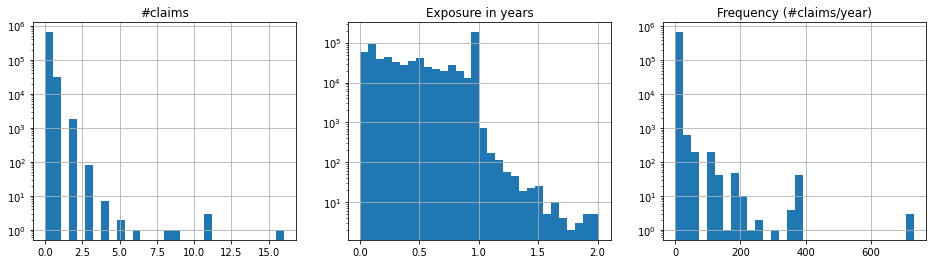

In [4]:
df["Frequency"] = df["ClaimNb"] / df["Exposure"]

print("Avg Frequency = {}"
      .format(np.average(df["Frequency"], weights=df["Exposure"])))

print("%Exposure with zero claims = {0:.1%}"
      .format(df.loc[df["ClaimNb"] == 0, "Exposure"].sum() /
              df["Exposure"].sum()))

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16, 4))
ax0.set_title("#claims")
_ = df["ClaimNb"].hist(bins=30, log=True, ax=ax0)
ax1.set_title("Exposure in years")
_ = df["Exposure"].hist(bins=30, log=True, ax=ax1)
ax2.set_title("Frequency (#claims/year)")
_ = df["Frequency"].hist(bins=30, log=True, ax=ax2)

- Remaining columns used to predict claim frequencies. Columns are a mix of datatypes with different scales & distributions.
- Need to do feature transforms first.

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer


log_scale_transformer = make_pipeline(
    FunctionTransformer(np.log, validate=False),
    StandardScaler()
)

linear_model_preprocessor = ColumnTransformer(
    [
        ("passthrough_numeric", "passthrough",
            ["BonusMalus"]),
        ("binned_numeric", KBinsDiscretizer(n_bins=10),
            ["VehAge", "DrivAge"]),
        ("log_scaled_numeric", log_scale_transformer,
            ["Density"]),
        ("onehot_categorical", OneHotEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"]),
    ],
    remainder="drop",
)

- Note: >93% of policyholders = zero claims. Converting this problem to binary classification means dataset would be badly imbalanced.
- To do evaluation use a baseline dummy estimator that constantly predicts mean frequency of training samples.

In [6]:
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    df, test_size=0.33, random_state=0)

dummy = Pipeline([
    ("preprocessor", 
     linear_model_preprocessor),
    ("regressor", 
     DummyRegressor(strategy='mean')),
]).fit(df_train, 
       df_train["Frequency"],
       regressor__sample_weight=df_train["Exposure"])

- Find baseline performance (score) with 3 regression metrics.

In [7]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_poisson_deviance


def score_estimator(estimator, df_test):
    """Score an estimator on the test set."""
    y_pred = estimator.predict(df_test)

    print("MSE: %.3f" %
          mean_squared_error(df_test["Frequency"], y_pred,
                             sample_weight=df_test["Exposure"]))
    print("MAE: %.3f" %
          mean_absolute_error(df_test["Frequency"], y_pred,
                              sample_weight=df_test["Exposure"]))

    # Ignore non-positive predictions (invalid for Poisson deviance.)
    mask = y_pred > 0
    if (~mask).any():
        n_masked, n_samples = (~mask).sum(), mask.shape[0]
        print(f"WARNING: Estimator yields invalid, non-positive predictions "
              f" for {n_masked} samples out of {n_samples}. These predictions "
              f"are ignored when computing the Poisson deviance.")

    print("mean Poisson deviance: %.3f" %
          mean_poisson_deviance(df_test["Frequency"][mask],
                                y_pred[mask],
                                sample_weight=df_test["Exposure"][mask]))

print("Constant mean frequency evaluation:")
score_estimator(dummy, df_test)

Constant mean frequency evaluation:
MSE: 0.564
MAE: 0.189
mean Poisson deviance: 0.625


- Model the target variable with a L2-penalized least squares linear regression (aka Ridge). Use a low value of ```alpha``` - expect the model to underfit such a large dataset.

In [8]:
from sklearn.linear_model import Ridge

ridge_glm = Pipeline([
    ("preprocessor", 
     linear_model_preprocessor),
    ("regressor", 
     Ridge(alpha=1e-6)),
]).fit(df_train, 
       df_train["Frequency"],
       regressor__sample_weight=df_train["Exposure"])

- Poisson deviance can't be used on negative values predicted by the model.

In [9]:
print("Ridge evaluation:")
score_estimator(ridge_glm, df_test)

Ridge evaluation:
MSE: 0.560
MAE: 0.177
mean Poisson deviance: 0.601


- Model the targets with a Poisson regressor. Use regularization strength ```alpha=1e-6``` to mimic the Ridge regressor - whose L2 penalty scales differently with the number of samples
- The Poisson regressor (internally) models the _log_ of the expected target value (log vs identity link function), the X/y relationship is no longer strictly linear.
- This is why the Poisson regressor is called a _Generalized Linear Model_ (GLM).

In [10]:
from sklearn.linear_model import PoissonRegressor

n_samples = df_train.shape[0]

poisson_glm = Pipeline([
    ("preprocessor", linear_model_preprocessor),
    ("regressor", PoissonRegressor(alpha=1e-12, max_iter=300))
])
poisson_glm.fit(df_train, df_train["Frequency"],
                regressor__sample_weight=df_train["Exposure"])

print("PoissonRegressor evaluation:")
score_estimator(poisson_glm, df_test)

PoissonRegressor evaluation:
MSE: 0.560
MAE: 0.186
mean Poisson deviance: 0.594


- Model the targets using a non-linear model (Gradient Boosting Regression Tree).
- GBRTs do not need one-hot encoded (via [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder)) category data. Instead we can add category data with arbitray integers via [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder). This will make the training faster.
- Gradient Boosting also allows fitting with Poisson loss function instead of the default least squares loss.

In [11]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder


tree_preprocessor = ColumnTransformer(
    [
        ("categorical", OrdinalEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"]),
        ("numeric", "passthrough",
            ["VehAge", "DrivAge", "BonusMalus", "Density"]),
    ],
    remainder="drop",
)
poisson_gbrt = Pipeline([
    ("preprocessor", tree_preprocessor),
    ("regressor", HistGradientBoostingRegressor(loss="poisson",
                                                max_leaf_nodes=128)),
])
poisson_gbrt.fit(df_train, df_train["Frequency"],
                 regressor__sample_weight=df_train["Exposure"])

print("Poisson Gradient Boosted Trees evaluation:")
score_estimator(poisson_gbrt, df_test)

Poisson Gradient Boosted Trees evaluation:
MSE: 0.564
MAE: 0.184
mean Poisson deviance: 0.575


- GBRTs minimize Poisson deviance.
- Evaluating models with a single train/test split is prone to random flunctuations. Use cross-validation to smooth out the data if compute time allows it.
- Model differences can be better understand via a observed-vs-predicted value histogram.

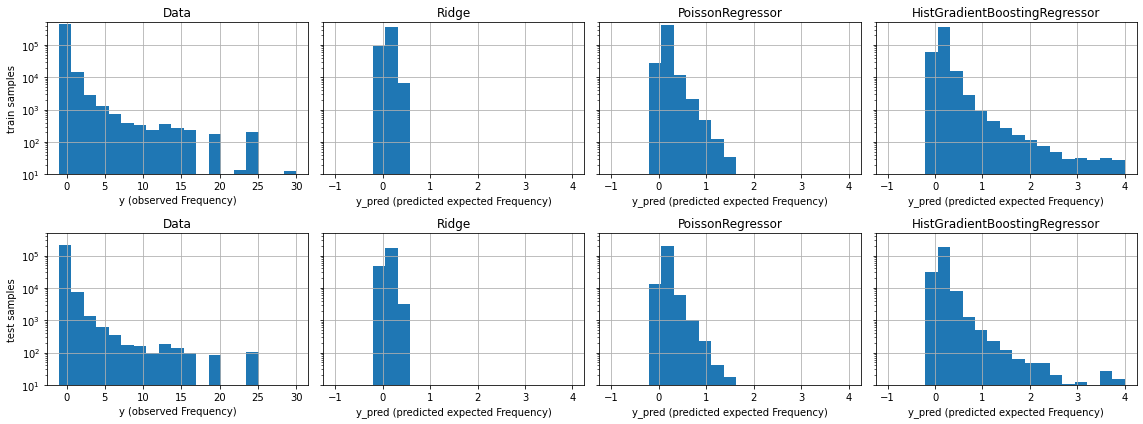

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), sharey=True)
fig.subplots_adjust(bottom=0.2)
n_bins = 20
for row_idx, label, df in zip(range(2),
                              ["train", "test"],
                              [df_train, df_test]):
    df["Frequency"].hist(bins=np.linspace(-1, 30, n_bins),
                         ax=axes[row_idx, 0])

    axes[row_idx, 0].set_title("Data")
    axes[row_idx, 0].set_yscale('log')
    axes[row_idx, 0].set_xlabel("y (observed Frequency)")
    axes[row_idx, 0].set_ylim([1e1, 5e5])
    axes[row_idx, 0].set_ylabel(label + " samples")

    for idx, model in enumerate([ridge_glm, poisson_glm, poisson_gbrt]):
        y_pred = model.predict(df)

        pd.Series(y_pred).hist(bins=np.linspace(-1, 4, n_bins),
                               ax=axes[row_idx, idx+1])
        axes[row_idx, idx + 1].set(
            title=model[-1].__class__.__name__,
            yscale='log',
            xlabel="y_pred (predicted expected Frequency)"
        )
plt.tight_layout()